# Анализ риска ДТП

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подключение-к-БД.-Загрузка-таблиц-SQL" data-toc-modified-id="Подключение-к-БД.-Загрузка-таблиц-SQL-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подключение к БД. Загрузка таблиц SQL</a></span></li><li><span><a href="#Первичное-исследование-таблиц" data-toc-modified-id="Первичное-исследование-таблиц-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Первичное исследование таблиц</a></span></li><li><span><a href="#Статистический-анализ-факторов-ДТП" data-toc-modified-id="Статистический-анализ-факторов-ДТП-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Статистический анализ факторов ДТП</a></span><ul class="toc-item"><li><span><a href="#Примеры-аналитических-задач" data-toc-modified-id="Примеры-аналитических-задач-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Примеры аналитических задач</a></span></li></ul></li><li><span><a href="#Подготовка-и-анализ-данных" data-toc-modified-id="Подготовка-и-анализ-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Подготовка и анализ данных</a></span></li><li><span><a href="#Создание-модели-для-оценки-водительского-риска" data-toc-modified-id="Создание-модели-для-оценки-водительского-риска-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Создание модели для оценки водительского риска</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Разделение данных на выборки</a></span></li><li><span><a href="#Преобразование-категориальных-и-количественных-признаков" data-toc-modified-id="Преобразование-категориальных-и-количественных-признаков-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Преобразование категориальных и количественных признаков</a></span></li><li><span><a href="#Обучение-моделей-и-выбор-наилучшей-из-них" data-toc-modified-id="Обучение-моделей-и-выбор-наилучшей-из-них-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Обучение моделей и выбор наилучшей из них</a></span></li><li><span><a href="#Определение-качества-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Определение-качества-лучшей-модели-на-тестовой-выборке-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Определение качества лучшей модели на тестовой выборке</a></span></li></ul></li><li><span><a href="#Анализ-важности-факторов-ДТП" data-toc-modified-id="Анализ-важности-факторов-ДТП-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Анализ важности факторов ДТП</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Описание проекта

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика:
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
  - Для модели выбрать тип виновника — только машина (car).
  - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
  - Для моделирования ограничиться данными за 2012 год — они самые свежие.
  - Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
  - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
  - Какие ещё факторы нужно учесть?
  - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

In [1]:
#!pip install -q optuna

## Импорт библиотек

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import optuna
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, confusion_matrix

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED = 777

## Подключение к БД. Загрузка таблиц SQL

In [3]:
db_config = {
'user': , # имя пользователя,
'pwd': , # пароль,
'host': , # хост
'port': , # порт подключения,
'db': # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

engine = create_engine(connection_string)

## Первичное исследование таблиц

Согласно исходным данным у нас 4 таблицы с детальной информацией о ДТП, выведем первые строки каждой таблицы:

In [4]:
tabs = ['case_ids', 'collisions', 'parties', 'vehicles']
for tab in tabs:
    query = f'''
                SELECT *
                FROM {tab}
                LIMIT 7;
             '''
    display(f'Таблица {tab}',
            pd.read_sql_query(query, con=engine))

'Таблица case_ids'

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021


'Таблица collisions'

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00


'Таблица parties'

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0


'Таблица vehicles'

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9


Предварительное знакомство с данными в таблицах показало, что:
- таблица `case_ids` содержит идентификационный номер зарегистрированного происшествия и год формирования/обновления базы данных. Так как поле case_id встречается во всех остальных таблицах, а техническая дата с ДТП никак не связана, то эта таблица в дальнейшем не понадобится;
- таблица `collisions` содержит информацию о происшествии: дату, время, место происшествия, погодные условия, уровень повреждений автомобиля, состояние дороги, освещение и другие факторы;
- таблица `parties` содержит информацию об участниках ДТП: тип участника ДТП, его номер в зависимости от количества участников происшествия, сумма страховки, физическое состояние, трезвость, наличие телефона в автомобиле. Целевой признак - at_fault - является ли участник происшествия виновником;
- таблица `vehicles` содержит описание автомобиля: тип кузова, КПП, возраст автомобиля.

##  Статистический анализ факторов ДТП

Для начала проанализируем какие месяцы самые "аварийные":

In [5]:
query = '''
           SELECT DISTINCT DATE_TRUNC('month', collision_date)::date as month,
                  COUNT(*) OVER(PARTITION BY DATE_TRUNC('month', collision_date))
           FROM collisions
           ORDER BY month;
        '''
months = pd.read_sql_query(query, con=engine)

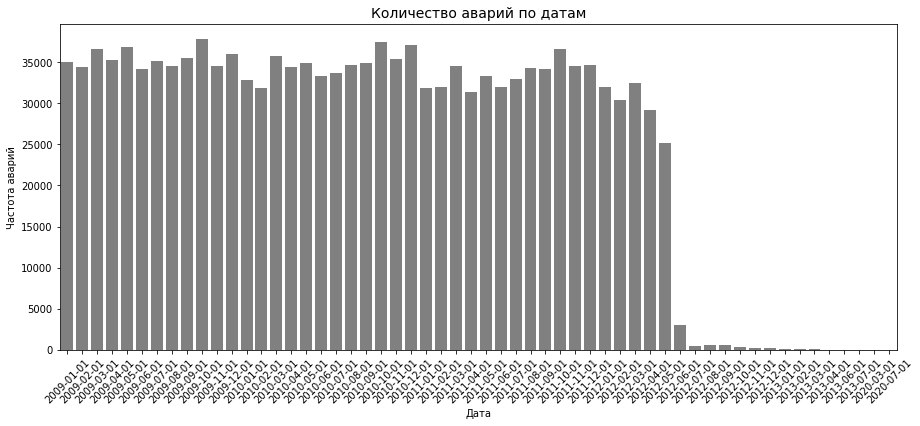

In [6]:
plt.figure(figsize=(15, 6))
sns.barplot(data = months, y = 'count', x = 'month', color='grey')
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Частота аварий')
plt.title('Количество аварий по датам', fontsize=14)
None

В мае 2012 года наблюдается резко падение количества зарегистированных случаев ДТП, возможно базу данных перестали актуализировать. Посмотрим на статистику ДТП в разрезе месяцев на данных до 2012 года:

In [7]:
query = '''
           SELECT DISTINCT EXTRACT(MONTH from collision_date)::int as month,
                  COUNT(*) OVER(PARTITION BY EXTRACT(MONTH from collision_date))
           FROM collisions
           WHERE EXTRACT(YEAR from collision_date) < 2012
           ORDER BY month;
        '''
collisions = pd.read_sql_query(query, con=engine)

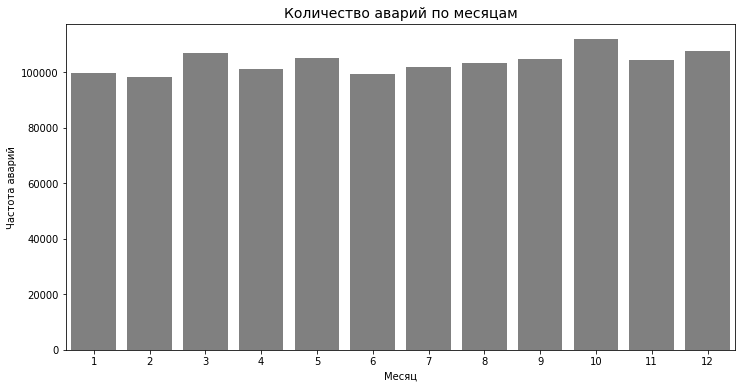

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(x=collisions['month'], y=collisions['count'], color='grey')
plt.xlabel('Месяц')
plt.ylabel('Частота аварий')
plt.title('Количество аварий по месяцам', fontsize=14)
None

In [9]:
query = '''
           SELECT COUNT(*)
           FROM collisions
           WHERE 1=1
             AND EXTRACT(YEAR from collision_date) < 2012
             AND EXTRACT(MONTH from collision_date) = 10;
        '''
pd.read_sql_query(query, con=engine)

,count
0,111933


Наибольшее количество аварий происходится на октябрь, декабрь и март, с пиком в октябре - 111 933 аварий. Такая статистика скорее всего связана со сменой сезона, и, как следствие, влияние погодных условий - гололеда, осадков, ухудшения видимости т.д.

### Примеры аналитических задач

**Задача 1**

**Какова средняя сумма выплаченной страховки по каждому типу повреждения автомобиля (таблицы parties и collisions).**

Для решения поставленной задачи необходимо:
- изучить признаки collision_damage (серьезность происшествия) и insurance_premium (сумма страховки, в тыс. долл.) в соответствующих таблицах collisions и parties;
- написать SQL-запрос и связать данные двух таблиц (collisions и parties) с агрегированием поля insurance_premium по AVG (для связывания 2 таблиц необходимо написать подзапрос с WITH):

In [10]:
query_task1 = '''
                WITH tab1 AS (
                SELECT p.case_id,
                       p.insurance_premium
                FROM parties AS p
                )
                
                SELECT c.collision_damage,
                       ROUND(AVG(tab1.insurance_premium), 2) AS avg_insurance
                FROM collisions AS c
                INNER JOIN tab1 ON c.case_id=tab1.case_id
                WHERE tab1.insurance_premium IS NOT NULL
                GROUP BY c.collision_damage
                ORDER BY avg_insurance DESC
                ;
              '''

- результат выдачи SQL-запроса записать в датафрейм с помощью метода pd.read_sql_query и вывести в виде сводной таблицы:

In [11]:
%%time
insurance_per_damage = pd.read_sql_query(query_task1, con=engine)
insurance_per_damage

CPU times: user 3.27 ms, sys: 0 ns, total: 3.27 ms
Wall time: 10.9 s


,collision_damage,avg_insurance
0,fatal,42.22
1,scratch,39.43
2,severe damage,38.72
3,small damage,38.50
4,middle damage,38.01


- сводная таблица получена, далее построим подходящую визуализацию (в данном случае barchart), значения средней страховки отсортированы по убыванию:

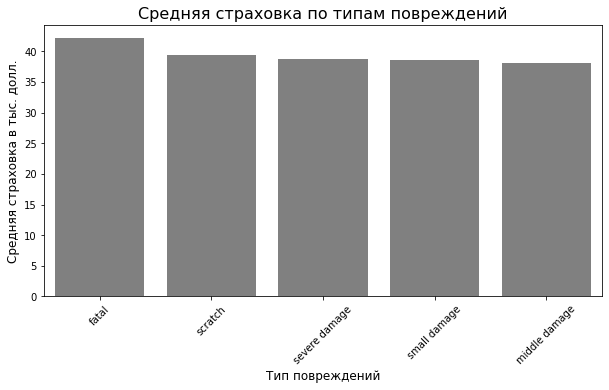

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(data = insurance_per_damage, x='collision_damage', y='avg_insurance', color='grey')
plt.title('Средняя страховка по типам повреждений', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Тип повреждений', fontsize=12)
plt.ylabel('Средняя страховка в тыс. долл.', fontsize=12)
plt.show()

- сделать вывод, например:

"Как видно из полученной сводной таблицы и визуализации, средняя сумма страховки примерно одинакова по типам повреждений, что скорее нелогично и требует дополнительного анализа: либо страховые выплаты завышены, либо проводится неверная оценка повреждений, либо в данных присутствует много выбросов (например, для небольших повреждений в базу могли вносить суммы не в тысячах долларов, а в единицах). 

При этом для повреждений типа fatal (не подлежит восстановлению) очевидно самые большие средние выплаты - около 42 тыс. долл., далее идет тип повреждений scratch (царапина) - 39 тыс. долл. - в данном случае также необходим дополнительный анализ. Как одной из мер для борьбы с завышенными выплатами - активное использование франшизы при страховании."

**Задача 2**

**Проанализировать возраст автомобилей (vehicle_age), которые в результате ДТП не подлежат восстановлению (тип fatal поля collision_damage) (таблицы vehicle и collisions)**

Для решения поставленной задачи необходимо:
- изучить признаки collision_damage (серьезность происшествия) и vehicle_age (Возраст автомобиля (в годах)) в соответствующих таблицах collisions и vehicle;
- написать SQL-запрос и связать данные двух таблиц collisions и vehicle (для связывания 2 таблиц необходимо написать подзапрос с WITH), чтобы исключить выбросы ограничим возраст автомобиля 20 годами:

In [13]:
query_task2 = '''
                WITH tab1 AS (
                SELECT v.case_id,
                       v.vehicle_age
                FROM vehicles AS v
                )
                
                SELECT tab1.case_id,
                       tab1.vehicle_age,
                       c.collision_damage
                FROM collisions AS c
                LEFT JOIN tab1 ON c.case_id=tab1.case_id
                WHERE c.collision_damage = 'fatal'
                    AND tab1.vehicle_age <= 20
                ;
              '''

- результат выдачи SQL-запроса записать в датафрейм с помощью метода pd.read_sql_query и вывести результат:

In [14]:
%%time
age_per_fatal = pd.read_sql_query(query_task2, con=engine)
age_per_fatal.head()

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 581 ms


,case_id,vehicle_age,collision_damage
0,4014901,9,fatal
1,4014908,5,fatal
2,3984245,11,fatal
3,3984274,9,fatal
4,3984278,9,fatal


- датафрейм получен, далее построим подходящую визуализацию (в данном случае histogram) для анализа плотности распределения vehicle_age:

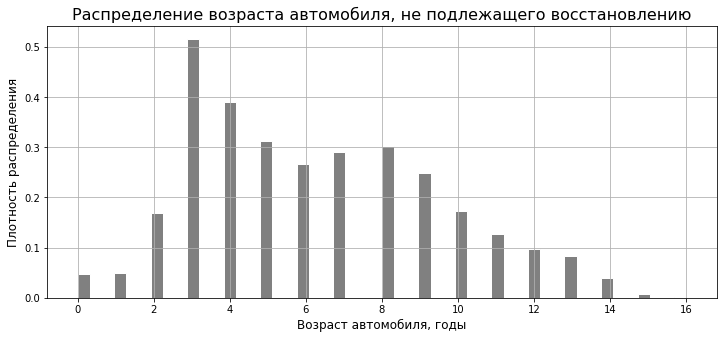

In [15]:
plt.figure(figsize=(12,5))
age_per_fatal['vehicle_age'].hist(bins=50, density=True, color='grey', edgecolor='white')
plt.title('Распределение возраста автомобиля, не подлежащего восстановлению', fontsize=16)
plt.xlabel('Возраст автомобиля, годы', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
None

- сделать вывод, например:

"Как видно из полученной гистограммы, возраст автомобиля, не подлежащего восстановлению, имеет распределение, схожее с нормальным. Чаще всего в ДТП с fatal попадают 3-хлетние автомобили - более 50% случаев. Примечательно, что новые автомобили (возраст 0-1 год) реже остальных попадают в ДТП с fatal - возможно это связано с тем, что на дорогах значительно меньше новых авто либо новые автомобили стали оснащаться дополнительными электронными системами безопасности, управляемости, курсовой устойчивости и т.д. Для уточнения причины такого распредения необходим дополнительный анализ данных."

**Задача 3**

Оценить серьезность повреждений транспортного средства в зависимости от трезвости участника (таблицы collisions и parties)

**Задача 4**

Проанализировать влияние погодных условий на вероятность возникновения ДТП (таблица collisions)

**Задача 5**

Проанализировать количество аварий с неподлежащим восстановлению автомобилем в зависимости от типа дороги (таблица collisions)

**Задача 6**

Проанализировать в какое время суток (часы) происходило наибольшее количество ДТП (таблица collisions)

**Задача 7**

Проанализировать взаимосвязь типа ДТП с типом кузова транспортного средства (таблицы collisions и vehicles)

**Задача 8**

Изучить взаимосвязь освещения и типов участников проишествия (collisions и parties)

## Подготовка и анализ данных

Выгрузим все данные за 2012 год, с типом участника 'car' и серьезностью происшествия любой кроме 'scratch'. Идентификационные номера происшествий, участников и порядковые номера в выгрузку не войдут. Для прогнозирования ДТП возьмем такие факторы, которые могут быть известны до начала поездки:

In [16]:
%%time
query = '''
           WITH
           c AS (SELECT *
                 FROM collisions
                 WHERE EXTRACT(YEAR from collision_date) = 2012
                       AND collision_damage <> 'scratch'),
           p AS (SELECT *
                 FROM parties
                 WHERE party_type = 'car')

           SELECT c.county_city_location,
                  c.county_location,
                  c.distance,
                  c.direction,
                  c.intersection,
                  c.weather_1,
                  c.location_type,
                  c.road_surface,
                  c.road_condition_1,
                  c.lighting,
                  c.control_device,
                  c.collision_date,
                  c.collision_time,
                  p.at_fault,
                  p.party_sobriety,
                  p.party_drug_physical,
                  p.cellphone_in_use,
                  v.vehicle_type,
                  v.vehicle_transmission,
                  v.vehicle_age
           FROM c
           JOIN p ON c.case_id=p.case_id
           LEFT OUTER JOIN vehicles AS v ON c.case_id=v.case_id
                                        AND v.party_number = p.party_number;
        '''
df = pd.read_sql_query(query, con=engine)

CPU times: user 1.9 s, sys: 316 ms, total: 2.21 s
Wall time: 27.7 s


Выведем 5 случайных строк нового датасета:

In [17]:
df.sample(5)

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
169129,1900,los angeles,0.0,None,1.0,clear,None,dry,normal,daylight,functioning,2012-05-07,15:55:00,1,had not been drinking,None,0.0,None,None,NaN
108282,3009,orange,500.0,west,0.0,cloudy,highway,dry,normal,None,none,2012-04-11,07:40:00,0,had not been drinking,None,0.0,sedan,auto,5.0
26920,1941,los angeles,0.0,south,NaN,clear,None,dry,construction,daylight,none,2012-01-30,12:41:00,0,had not been drinking,None,0.0,None,None,NaN
16093,3905,san joaquin,43.0,east,0.0,clear,highway,dry,normal,daylight,none,2012-01-23,14:45:00,0,had not been drinking,None,0.0,None,None,NaN
43194,4120,san mateo,0.0,None,0.0,clear,None,dry,normal,dark with street lights,none,2012-01-09,18:10:00,1,had not been drinking,None,0.0,None,None,NaN


Посмотрим общую информацию о датасете:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   county_city_location  196837 non-null  object 
 1   county_location       196837 non-null  object 
 2   distance              196837 non-null  float64
 3   direction             153975 non-null  object 
 4   intersection          195850 non-null  float64
 5   weather_1             196183 non-null  object 
 6   location_type         87357 non-null   object 
 7   road_surface          195564 non-null  object 
 8   road_condition_1      195694 non-null  object 
 9   lighting              196116 non-null  object 
 10  control_device        195864 non-null  object 
 11  collision_date        196837 non-null  object 
 12  collision_time        195464 non-null  object 
 13  at_fault              196837 non-null  int64  
 14  party_sobriety        193212 non-null  object 
 15  

In [19]:
df.describe()

,distance,intersection,at_fault,cellphone_in_use,vehicle_age
count,1.968370e+05,195850.000000,196837.000000,171464.000000,54554.000000
mean,6.624782e+02,0.201899,0.523514,0.023632,4.856472
std,7.915264e+03,0.401419,0.499448,0.151899,3.234503
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+01,0.000000,0.000000,0.000000,3.000000
50%,1.000000e+02,0.000000,1.000000,0.000000,4.000000
75%,5.000000e+02,0.000000,1.000000,0.000000,7.000000
max,1.584000e+06,1.000000,1.000000,1.000000,161.000000


Посмотрим на количество пропусков в столбцах:

In [20]:
df.isna().sum()

county_city_location         0
county_location              0
distance                     0
direction                42862
intersection               987
weather_1                  654
location_type           109480
road_surface              1273
road_condition_1          1143
lighting                   721
control_device             973
collision_date               0
collision_time            1373
at_fault                     0
party_sobriety            3625
party_drug_physical     171689
cellphone_in_use         25373
vehicle_type            140589
vehicle_transmission    141448
vehicle_age             142283
dtype: int64

Таким образом, в получившемся датасете 196837 строк и 20 столбцов, в данных много пропусков: в некоторых столбцах тип данных не соответствует содержимому. В столбцах `distance` и `vehicle_age` есть выбросы: например, возврат авто 161 год или расстояние от главной дороги 1584000 метров.

Подробнее пройдемся по каждому столбцу:

In [21]:
columns = ['county_city_location', 'county_location', 'direction',
              'intersection', 'weather_1', 'location_type', 'road_surface',
              'road_condition_1', 'lighting', 'control_device','party_sobriety',
              'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
              'vehicle_transmission'
             ]

for column in columns:
    print(f'{column}:',
          df[column].value_counts(dropna=False).nlargest(3),
          f'Всего категорий: {len(df[column].unique())}',
          sep='\n',
          end='\n\n')

county_city_location:
1942    23010
1900     7419
3400     3743
Name: county_city_location, dtype: int64
Всего категорий: 513

county_location:
los angeles       64488
orange            18509
san bernardino    11428
Name: county_location, dtype: int64
Всего категорий: 58

direction:
north    42980
NaN      42862
south    42703
Name: direction, dtype: int64
Всего категорий: 5

intersection:
0.0    156308
1.0     39542
NaN       987
Name: intersection, dtype: int64
Всего категорий: 3

weather_1:
clear      157335
cloudy      29497
raining      8112
Name: weather_1, dtype: int64
Всего категорий: 8

location_type:
NaN        109480
highway     71914
ramp        11526
Name: location_type, dtype: int64
Всего категорий: 4

road_surface:
dry    175564
wet     18920
NaN      1273
Name: road_surface, dtype: int64
Всего категорий: 5

road_condition_1:
normal          189563
construction      3355
NaN               1143
Name: road_condition_1, dtype: int64
Всего категорий: 9

lighting:
daylight   

В столбце county_city_location очень много категорий - 513, кроме того они входят в состав категорий столбца county_location, поэтому имеет смысл его не использовать.

В столбце county_location 58 категорий, объединим те из них, в которых было менее 2500 ДТП в одну категорию:

In [22]:
def cat_func(df, column_name, number, category_name):
    values = df[column_name].value_counts(dropna=False)
    idx_list = values[values < number].index
    df.loc[df[column_name].isin(idx_list), column_name] = category_name
    display(df[column_name].value_counts(dropna=False))

In [23]:
cat_func(df, 'county_location', 2500, 'other')

los angeles       64488
other             30016
orange            18509
san bernardino    11428
riverside         10776
san diego         10060
alameda            8224
sacramento         7478
santa clara        7018
ventura            4976
contra costa       4333
kern               4252
san mateo          3721
san joaquin        2965
fresno             2954
tulare             2896
santa barbara      2743
Name: county_location, dtype: int64

В столбце direction 42862 пропуска, заполним их значением 'unknown':

In [24]:
df.loc[df['direction'].isna(), 'direction'] = 'unknown'

In [25]:
df['direction'].value_counts()

north      42980
unknown    42862
south      42703
west       34276
east       34016
Name: direction, dtype: int64

В столбцах с типом дороги location_type достаточно большое количество пропусков - 109480, заполним пропущенные значения в них как other:

In [26]:
df['location_type'] = df['location_type'].fillna('other')

In [27]:
df['location_type'].isna().sum()

0

В столбце intersection переименуем значения признака, чтобы в дальнейшем не возникло ошибок при работе с CatBoost:

In [28]:
df['intersection'] = df['intersection'].replace({0.0: 'no', 1.0: 'yes'})

В столбце weather_1 все значения, кроме пропусков, 'clear' и 'cloudy' отнесем в группу 'other', поскольку их значительно меньше остальных категорий:

In [29]:
cat_func(df, 'weather_1', 9000, 'other')

clear     157335
cloudy     29497
other       9351
NaN          654
Name: weather_1, dtype: int64

В столбце road_condition_1 все значения, кроме пропущенных и 'normal' определим в группу 'abnormal', поскольку их также значительно меньше категории 'normal':

In [30]:
cat_func(df, 'road_condition_1', 4000, 'abnormal')

normal      189563
abnormal      6131
NaN           1143
Name: road_condition_1, dtype: int64

Аналогично, в столбце lighting объединим в категорию 'other' все значения, которые встречаются менее 15000 раз:

In [31]:
cat_func(df, 'lighting', 15000, 'no lighting')

daylight                   136370
dark with street lights     38095
no lighting                 21651
NaN                           721
Name: lighting, dtype: int64

В столбце control_device все значения, кроме 'functioning' отнесем к категории 'none':

In [32]:
cat_func(df, 'control_device', 1000, 'none')

none           133225
functioning     62639
NaN               973
Name: control_device, dtype: int64

В столбце party_sobriety отнесем все значения, кроме 'had not been drinking' к категории 'other':

In [33]:
cat_func(df, 'party_sobriety', 21000, 'had been drinking')

had not been drinking    157684
had been drinking         35528
NaN                        3625
Name: party_sobriety, dtype: int64

В столбцах party_drug_physical, cellphone_in_use, vehicle_type и vehicle_transmission слишком много пропущенных значений. Не будем использовать эти данные для обучения модели.

В столбце vehicle_age 142 283 пропущенных значений, но так как обязательное условие проекта учесть этот фактор, поэтому заполним пропуски линейно интерполированным значением и медианой:

In [34]:
df['vehicle_age'] = df['vehicle_age'].interpolate(method='linear').fillna(df['vehicle_age'].median()).astype('int')

Посмотрим на распределение значений:

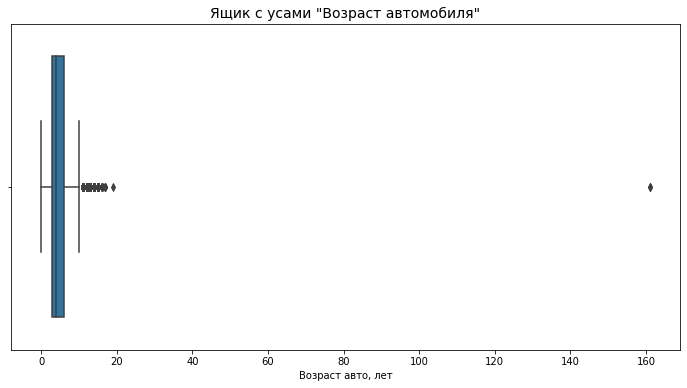

In [35]:
plt.figure(figsize=[12, 6])
sns.boxplot(data=df, orient='h', x='vehicle_age')
plt.xlabel('Возраст авто, лет')
plt.title('Ящик с усами "Возраст автомобиля"', fontsize=14)
None

За исключением выбросов в данных, автомобили старше 20 лет в датасете не встречаются - удалим их. И проведем сравнительный анализ возраста авто, являющееся и не являющееся виновником ДТП:

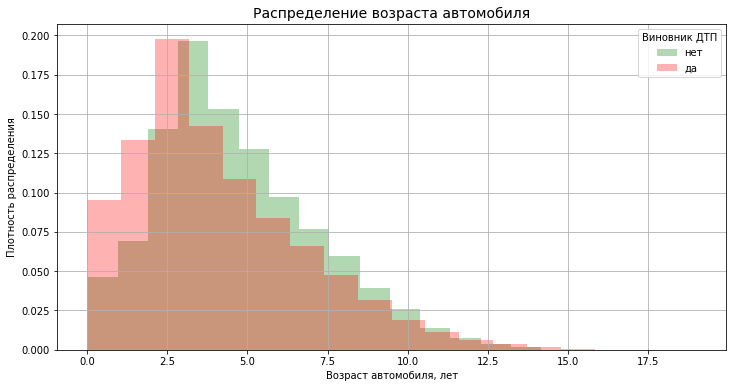

In [36]:
df = df[~(df['vehicle_age'] > 20)]

plt.figure(figsize=(12, 6))
plt.title('Распределение возраста автомобиля', fontsize=14)
plt.xlabel('Возраст автомобиля, лет')
plt.ylabel('Плотность распределения')
df.loc[df['at_fault'] == 0 , 'vehicle_age'].hist(bins=18, density=True, alpha=0.3, color='green')
df.loc[df['at_fault'] == 1 , 'vehicle_age'].hist(bins=18, density=True, alpha=0.3, color='red')
plt.legend(['нет', 'да'],
           title='Виновник ДТП')
None

Виновниками ДТП чаще становятся водители, возраст автомобилей которых  не старше 5 лет.

Скорее всего каршеринговая компания не будет эксплуатировать автомобили старше 3-5 лет, поскольку к 5 годам у авто серьезные пробеги и износ систем и агрегатов, а это влечет за собой бОльшие расходы на техническое обслуживание. Также наличие возрастных авто в парке каршеринговой компании может сказаться на ее имиджевой составляющей: клиентам будет не комфортно ездить на старых авто. Поэтому для дальнейшего исследования ограничим возраст авто 5 годами.

In [37]:
#df.loc[(df['vehicle_age'] >= 0) & (df['vehicle_age'] <= 5), 'age_cat'] = 1
#df.loc[df['vehicle_age'].isna(), 'age_cat'] = 0
#df.loc[df['vehicle_age'] > 5, 'age_cat'] = 2

Посмотрим на столбец distance:

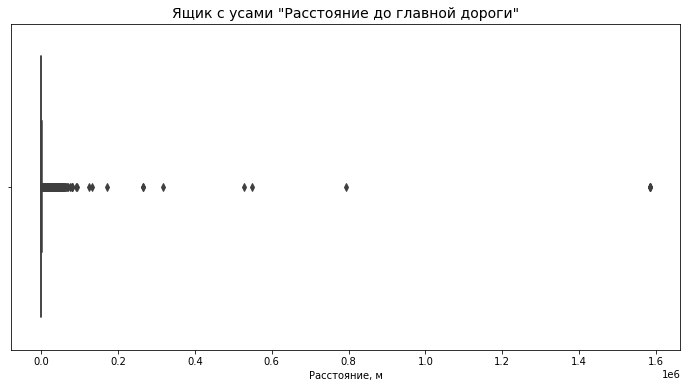

In [38]:
plt.figure(figsize=[12, 6])
sns.boxplot(data=df, orient='h', x='distance')
plt.xlabel('Расстояние, м')
plt.title('Ящик с усами "Расстояние до главной дороги"', fontsize=14)
None

Возьмем 95 перцентиль и посмотрим на распределение:

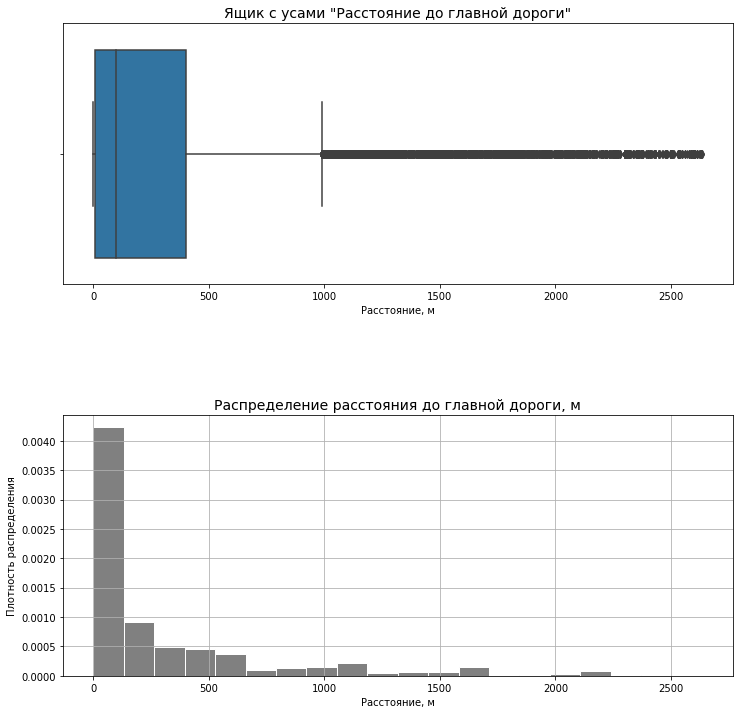

In [39]:
df = df[df['distance'] < np.percentile(df['distance'], 95)]

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sns.boxplot(data=df, orient='h', x='distance')
plt.xlabel('Расстояние, м')
plt.title('Ящик с усами "Расстояние до главной дороги"', fontsize=14)

plt.subplot(2, 1, 2)
df['distance'].hist(bins=20, density=True, color='grey', edgecolor='white')
plt.title('Распределение расстояния до главной дороги, м', fontsize=14)
plt.xlabel('Расстояние, м')
plt.ylabel('Плотность распределения')
plt.subplots_adjust(hspace=0.5)
None

Расстояние до главное дороги имеет распределение, схожее с экспоненциальным. Большинство аварий происходит на главной дороге или вблизи.

Рассмотрим столбцы collision_date и collision_time. Из collision_date извлечем месяцы, а collision_time категоризируем по часам:

In [40]:
df['month'] = pd.to_datetime(df['collision_date'], format='%Y-%m-%d').dt.month

df['hour'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour
df.loc[(df['hour'] >= 5) & (df['hour'] < 11), 'hour_cat'] = 'утро'
df.loc[(df['hour'] >= 11) & (df['hour'] < 17), 'hour_cat'] = 'день'
df.loc[(df['hour'] >= 17) & (df['hour'] < 23), 'hour_cat'] = 'вечер'
df.loc[(df['hour'] >= 23) | (df['hour'] < 5), 'hour_cat'] = 'ночь'

Таким образом, для дальнейшей оценки важности факторов, отобрали следующие признаки:

In [41]:
columns = [
    'county_location',  # место происшествия, таблица collisions
    'direction',        # направление движения, таблица collisions
    'intersection',     # является ли место происшествия перекрестком, таблица collisions
    'location_type',    # тип дороги, таблица collisions
    'weather_1',        # погодные условия, таблица collisions
    'road_surface',     # состояние дороги исходя из погодных условий, таблица collisions
    'road_condition_1', # состояние дорожного полотна, таблица collisions
    'lighting',         # освещение, таблица collisions
    'control_device',   # устройство управления, таблица collisions
    'party_sobriety',   # трезвость участника, таблица parties
    'distance',         # расстояние от главной дороги, таблица collisions
    'month',            # месяц происшествия, таблица collisions
    'hour_cat',         # время суток происшествия, таблица collisions
    'vehicle_age'       # dозраст автомобиля (в годах), таблица vehicles 
]

Целевой признак:

In [42]:
target = 'at_fault'

Посчитаем строки с пропущенными данными:

In [43]:
df[columns].isna().sum()

county_location        0
direction              0
intersection         986
location_type          0
weather_1            629
road_surface        1240
road_condition_1    1124
lighting             701
control_device       945
party_sobriety      3452
distance               0
month                  0
hour_cat            1293
vehicle_age            0
dtype: int64

8718 это примерно 4.4% датасета. Удалим их:

In [44]:
df = df[columns + [target]]
df = df.dropna(axis=0)

Проверим, что строки с пропущенными значениями удалены:

In [45]:
df[columns].isna().any(axis = 1).sum()

0

Как было упомянуто выше, ограничим возраст автомобилей 5 годами (в каршеринге скорее всего авто старше 5 лет не будут эксплуатироваться):

In [46]:
df = df[~(df['vehicle_age'] > 5)]

Столбцы с категориальными и числовыми данными выделим в отдельные столбцы:

In [47]:
categorical = [
    'county_location', 'direction', 'intersection', 'weather_1',
    'road_surface', 'road_condition_1', 'lighting', 'control_device',
    'party_sobriety', 'month', 'location_type', 'hour_cat'#, 'age_cat', 
]


numeric = ['distance', 'vehicle_age']

Посмотрим распределение категориальных данных:

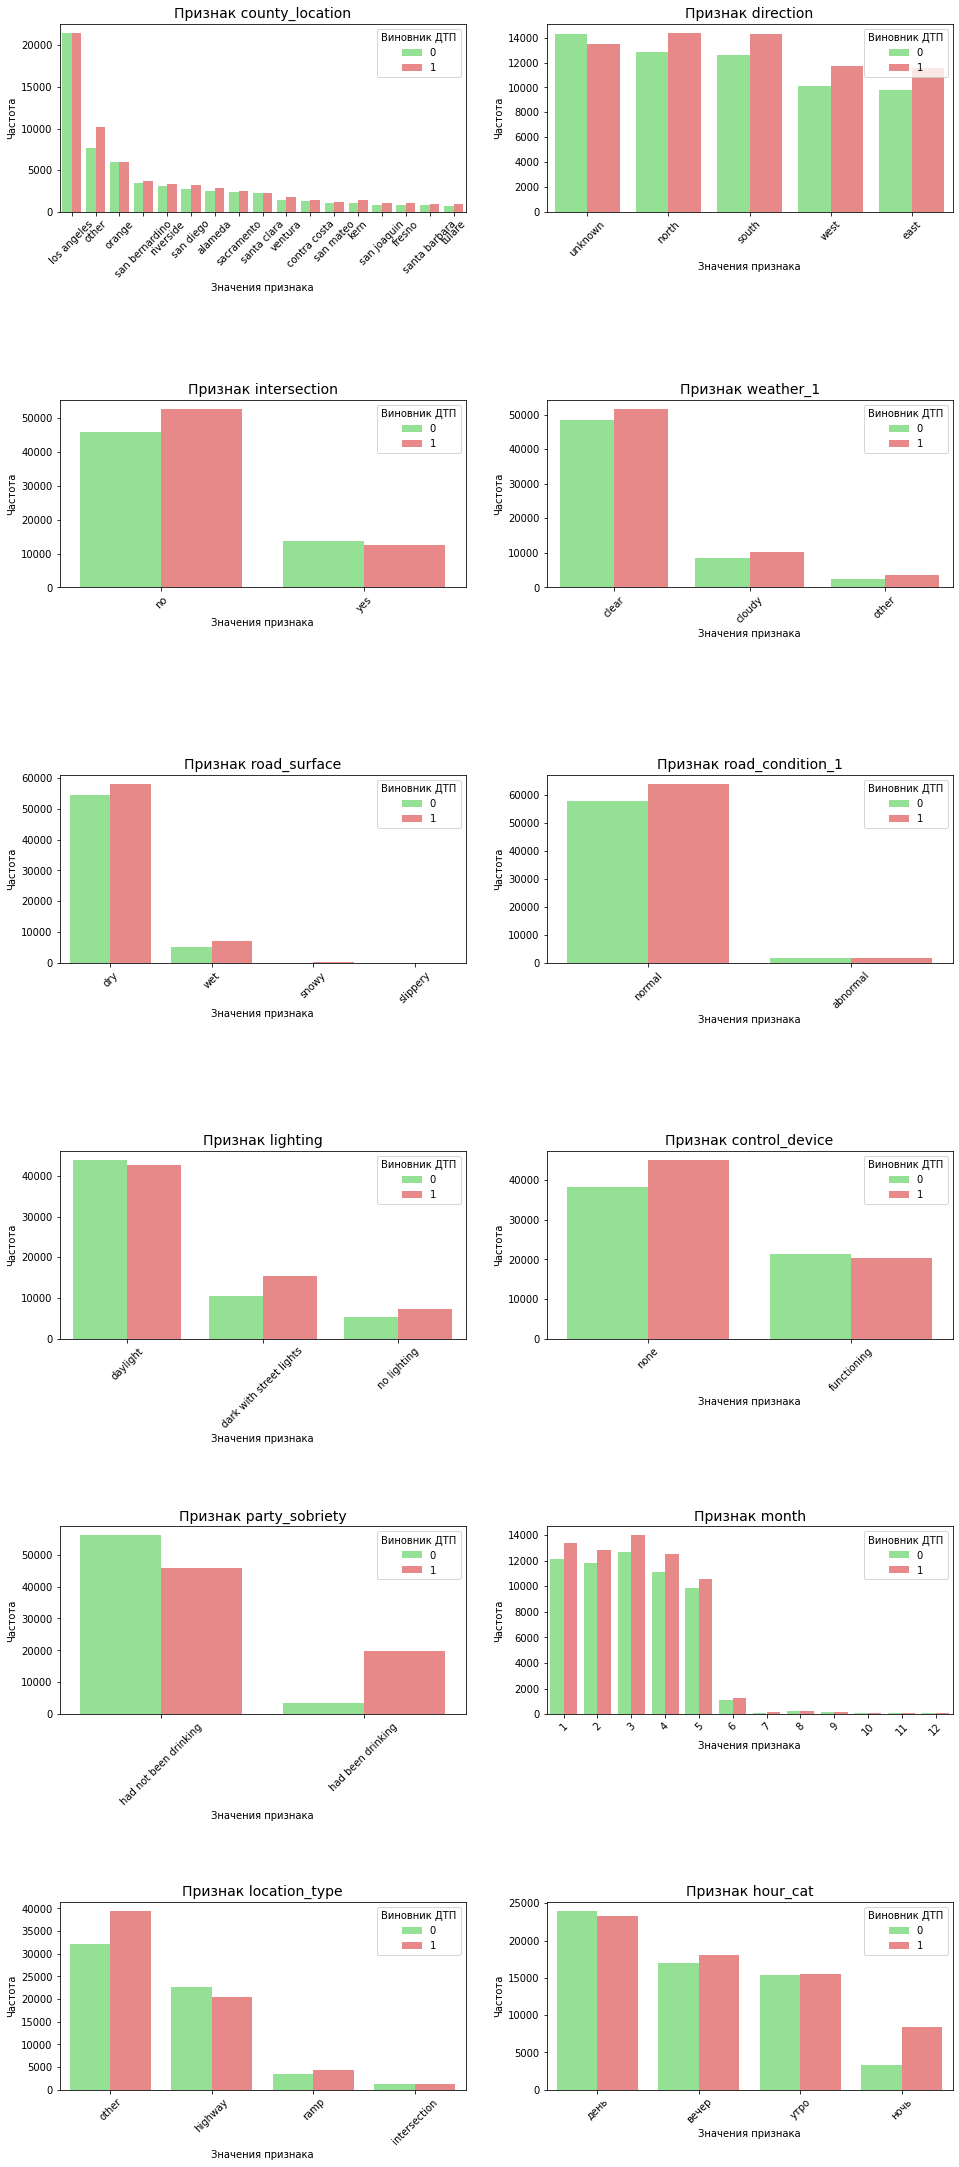

In [48]:
cnt = 1
plt.figure(figsize=(16, 38))
plt.subplots_adjust(hspace=1)

colors = ["#87ed89", "#f77979"]
sns.set_palette(sns.color_palette(colors))

for column in categorical:
    plt.subplot(6, 2, cnt)
    tmp = df.groupby('at_fault')[column].value_counts().rename('count').reset_index()
    sns.barplot(data = tmp, y = 'count', x = column, hue = 'at_fault')
    plt.xticks(rotation = 45)
    plt.xlabel('Значения признака')
    plt.ylabel('Частота')
    plt.title(f'Признак {column}', fontsize=14)
    plt.legend(title='Виновник ДТП')
    cnt += 1
None

Проанализировав полученные визуализации, можно сделать вывод, что большинство ДТП произошло:
- в Лос-Анджелесе;
- не на перекрестке;
- в ясную сухую погоду;
- на дорожном покрытии в нормальном состоянии;
- в дневное время суток.

Доля виновных в ДТП выше относительно доли невиновных в авариях:
- произошедших в ночное время суток;
- под влиянием алкогольного опьянения;
- возраст автомобиля до 5 лет или не указан;
- с выключенным устройством управления.

## Создание модели для оценки водительского риска

### Разделение данных на выборки

In [49]:
X = df.drop(['at_fault'], axis=1)
y = df['at_fault']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=SEED,
                                                    shuffle=True,
                                                    stratify=y)

print('Размеры получившихся выборок:\n '
      'X_train:',X_train.shape, '\n',
      'X_test:', X_test.shape, '\n',
      'y_train:', y_train.shape, '\n',
      'y_test:', y_test.shape)

Размеры получившихся выборок:
 X_train: (93829, 14) 
 X_test: (31277, 14) 
 y_train: (93829,) 
 y_test: (31277,)


### Преобразование категориальных и количественных признаков

Отмасштабируем количественные признаки с помощью структуры StandardScaler:

In [51]:
#from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipeline
#si_0 = SimpleImputer(strategy='constant', fill_value=0)
#ss = StandardScaler()
#ohe = OneHotEncoder()

In [52]:
#categorical_pipe = Pipeline([('si_0', si_0), ('ohe', ohe)])
#numeric_pipe = Pipeline([('si_0', si_0), ('ss', ss)])

In [53]:
#col_transformer = ColumnTransformer(
#                    transformers=[
#                        ('nums', numeric_pipe, numeric),
#                        ('cats', categorical_pipe, categorical)
#                    ],
#                    remainder='drop',
#                    n_jobs=-1
#                    )
#
#X_train = col_transformer.fit_transform(X_train)
#X_test = col_transformer.transform(X_test)

In [54]:
#col_transformer = ColumnTransformer(
#                            transformers=[
#                                ('scaler', StandardScaler(), numeric),
#                                ('ohe', OneHotEncoder), categorical)],)
#
#X_train = col_transformer.fit_transform(X_train)
#X_test = col_transformer.transform(X_test)

In [55]:
ss = StandardScaler()

In [56]:
ss.fit(X_train[numeric])
X_train[numeric] = ss.transform(X_train[numeric])
X_test[numeric] = ss.transform(X_test[numeric])

In [57]:
display(X_train[numeric].head())
display(X_test[numeric].head())

,distance,vehicle_age
171102,0.285137,-2.128454
38580,-0.480647,0.008998
173265,-0.611495,0.721482
192820,0.203625,0.008998
21594,0.418131,1.433967


,distance,vehicle_age
37032,-0.632946,1.433967
161541,-0.010880,-0.703486
122162,-0.590045,1.433967
130182,-0.225386,-0.703486
191794,-0.611495,0.008998


Теперь преобразуем категориальные признаки, предварительно изменив тип данных в категориальных столбцах на 'category':

In [58]:
for cat in categorical:
    X_train[cat] = X_train[cat].astype('category')
    X_test[cat] = X_test[cat].astype('category')

Сначала преобразуем данные для обучающей выборки:

In [59]:
ohe = OneHotEncoder(handle_unknown='error', drop='first')

In [60]:
X_train_encoder = X_train.loc[:]
ohe.fit(X_train_encoder[categorical])
X_train_encoded = ohe.transform(X_train_encoder[categorical]).toarray()
X_train_encoded

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [61]:
X_train_df = pd.DataFrame(
    X_train_encoded, 
    columns=ohe.get_feature_names(categorical),
    index=X_train.index
)
X_train_df.head()

,county_location_contra costa,county_location_fresno,county_location_kern,county_location_los angeles,county_location_orange,county_location_other,county_location_riverside,county_location_sacramento,county_location_san bernardino,county_location_san diego,county_location_san joaquin,county_location_san mateo,county_location_santa barbara,county_location_santa clara,county_location_tulare,county_location_ventura,direction_north,direction_south,direction_unknown,direction_west,intersection_yes,weather_1_cloudy,weather_1_other,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_normal,lighting_daylight,lighting_no lighting,control_device_none,party_sobriety_had not been drinking,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,location_type_intersection,location_type_other,location_type_ramp,hour_cat_день,hour_cat_ночь,hour_cat_утро
171102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
38580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
173265,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
192820,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [62]:
X_train_sc = pd.concat((X_train[numeric], X_train_df), axis=1)
X_train_sc.head()

,distance,vehicle_age,county_location_contra costa,county_location_fresno,county_location_kern,county_location_los angeles,county_location_orange,county_location_other,county_location_riverside,county_location_sacramento,county_location_san bernardino,county_location_san diego,county_location_san joaquin,county_location_san mateo,county_location_santa barbara,county_location_santa clara,county_location_tulare,county_location_ventura,direction_north,direction_south,direction_unknown,direction_west,intersection_yes,weather_1_cloudy,weather_1_other,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_normal,lighting_daylight,lighting_no lighting,control_device_none,party_sobriety_had not been drinking,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,location_type_intersection,location_type_other,location_type_ramp,hour_cat_день,hour_cat_ночь,hour_cat_утро
171102,0.285137,-2.128454,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
38580,-0.480647,0.008998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
173265,-0.611495,0.721482,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
192820,0.203625,0.008998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21594,0.418131,1.433967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Аналогично, для тестовой выборки:

In [63]:
X_test_encoder = X_test.loc[:]
X_test_encoded = ohe.transform(X_test_encoder[categorical]).toarray()
X_test_encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [64]:
X_test_df = pd.DataFrame(
    X_test_encoded, 
    columns=ohe.get_feature_names(categorical),
    index=X_test.index
)
X_test_df.head()

,county_location_contra costa,county_location_fresno,county_location_kern,county_location_los angeles,county_location_orange,county_location_other,county_location_riverside,county_location_sacramento,county_location_san bernardino,county_location_san diego,county_location_san joaquin,county_location_san mateo,county_location_santa barbara,county_location_santa clara,county_location_tulare,county_location_ventura,direction_north,direction_south,direction_unknown,direction_west,intersection_yes,weather_1_cloudy,weather_1_other,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_normal,lighting_daylight,lighting_no lighting,control_device_none,party_sobriety_had not been drinking,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,location_type_intersection,location_type_other,location_type_ramp,hour_cat_день,hour_cat_ночь,hour_cat_утро
37032,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
161541,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
130182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191794,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [65]:
X_test_sc = pd.concat((X_test[numeric], X_test_df), axis=1)
X_test_sc.head()

,distance,vehicle_age,county_location_contra costa,county_location_fresno,county_location_kern,county_location_los angeles,county_location_orange,county_location_other,county_location_riverside,county_location_sacramento,county_location_san bernardino,county_location_san diego,county_location_san joaquin,county_location_san mateo,county_location_santa barbara,county_location_santa clara,county_location_tulare,county_location_ventura,direction_north,direction_south,direction_unknown,direction_west,intersection_yes,weather_1_cloudy,weather_1_other,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_normal,lighting_daylight,lighting_no lighting,control_device_none,party_sobriety_had not been drinking,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,location_type_intersection,location_type_other,location_type_ramp,hour_cat_день,hour_cat_ночь,hour_cat_утро
37032,-0.632946,1.433967,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
161541,-0.010880,-0.703486,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122162,-0.590045,1.433967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
130182,-0.225386,-0.703486,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191794,-0.611495,0.008998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [66]:
print(f'Размеры обучающей выборки после преобразования: {X_train_sc.shape}')
print(f'Размеры тестовой выборки после преобразования: {X_test_sc.shape}')

Размеры обучающей выборки после преобразования: (93829, 50)
Размеры тестовой выборки после преобразования: (31277, 50)


### Обучение моделей и выбор наилучшей из них

Рассмотрим следующие модели и перебором их гиперпараметров подберем для них наилучшие с помощью инструмента optuna:
- RandomForestClassifier,
- LGBMClassifier,
- CatBoostClassifier.

Рассмотрим RandomForestClassifier:

In [67]:
def objective(trial):
  
    rfc_params = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 250, 10),
        "max_depth": trial.suggest_int('max_depth', 5, 9),
        "min_samples_split": trial.suggest_int('min_samples_split', 6, 9)
    }
  
    rfc = RandomForestClassifier(**rfc_params, class_weight='balanced', random_state=SEED)
    rfc.fit(X_train_sc, y_train)
    roc_auc = roc_auc_score(y_test, rfc.predict(X_test_sc))
    return roc_auc

In [68]:
#%%time
#rfc_study = optuna.create_study(direction='maximize')
#rfc_study.optimize(objective, n_trials=10)

In [69]:
#rfc_study.best_trial

FrozenTrial(number=6, values=[0.6286603151651856], datetime_start=datetime.datetime(2022, 11, 23, 14, 41, 19, 779511), datetime_complete=datetime.datetime(2022, 11, 23, 14, 41, 26, 891513), params={'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 6}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=10), 'max_depth': IntDistribution(high=9, log=False, low=5, step=1), 'min_samples_split': IntDistribution(high=9, log=False, low=6, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=6, state=TrialState.COMPLETE, value=None)

Рассмотрим LGBMClassifier:

In [70]:
def objective(trial):
  
    lgbm_params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 200, 10),
        "max_depth": trial.suggest_int('max_depth', 3, 5),
        "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.01, log=True)
    }
  
    lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight='balanced', random_state=SEED)
    lgbm.fit(X_train, y_train, verbose=0)
    roc_auc = roc_auc_score(y_test, lgbm.predict(X_test))
    return roc_auc

In [71]:
#lgbm_study = optuna.create_study(direction='maximize')
#lgbm_study.optimize(objective, n_trials=5)

In [72]:
#lgbm_study.best_trial

FrozenTrial(number=0, values=[0.6271827655281944], datetime_start=datetime.datetime(2022, 11, 23, 14, 13, 35, 647902), datetime_complete=datetime.datetime(2022, 11, 23, 14, 19, 25, 84354), params={'n_estimators': 140, 'max_depth': 5, 'learning_rate': 0.007575562958141199}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=100, step=10), 'max_depth': IntDistribution(high=5, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

Рассмотрим CatBoostClassifier:

In [73]:
def objective(trial):
  
    cbc_params = {
        "objective": trial.suggest_categorical("objective", ['Logloss', 'CrossEntropy']),
        "iterations": trial.suggest_int('iterations', 50, 250, log=True),
        "depth": trial.suggest_int('depth', 5, 7),
        "early_stopping_rounds": trial.suggest_int('early_stopping_rounds', 10, 40, log=True),
        "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.01, log=True)
    }
  
    cbc = CatBoostClassifier(**cbc_params, cat_features=categorical, random_seed=SEED)
    cbc.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
    roc_auc = roc_auc_score(y_test, cbc.predict(X_test))
    return roc_auc

In [74]:
#cbc_study = optuna.create_study(direction='maximize')
#cbc_study.optimize(objective, n_trials=10)

In [75]:
#cbc_study.best_trial

FrozenTrial(number=3, values=[0.6246103945612762], datetime_start=datetime.datetime(2022, 11, 23, 14, 35, 4, 240032), datetime_complete=datetime.datetime(2022, 11, 23, 14, 35, 39, 435885), params={'objective': 'CrossEntropy', 'iterations': 236, 'depth': 7, 'early_stopping_rounds': 24, 'learning_rate': 0.005058818473689313}, distributions={'objective': CategoricalDistribution(choices=('Logloss', 'CrossEntropy')), 'iterations': IntDistribution(high=250, log=True, low=50, step=1), 'depth': IntDistribution(high=7, log=False, low=5, step=1), 'early_stopping_rounds': IntDistribution(high=40, log=True, low=10, step=1), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)

Полученные гиперпараметры используем для обучения моделей:

Для RandomForestClassifier:

In [76]:
rfc_best_params = {
    "n_estimators": 140,
    "max_depth": 8,
    "min_samples_split": 6
}

rfc_best_model = RandomForestClassifier(**rfc_best_params, class_weight='balanced', random_state=SEED)

In [77]:
%%time
rfc_scores = cross_val_score(
    rfc_best_model, X_train_sc, y_train, cv=5, scoring='roc_auc'
)
print('Средняя ROC-AUC модели: %.4f' % (rfc_scores.mean()))

#Wall time: 27.1 s

Средняя ROC-AUC модели: 0.6557
CPU times: user 25.6 s, sys: 84.8 ms, total: 25.6 s
Wall time: 25.7 s


Для LGBMClassifier:

In [78]:
lgbm_best_params = {
    'n_estimators': 140, 
    'max_depth': 5, 
    'learning_rate': 0.007575562958141199
}
  
lgbm_best_model = lgb.LGBMClassifier(**lgbm_best_params, class_weight='balanced', random_state=SEED)

In [79]:
%%time
lgbm_scores = cross_val_score(
    lgbm_best_model, X_train, y_train, cv=5, scoring='roc_auc'
)
print('Средняя ROC-AUC модели: %.4f' % (lgbm_scores.mean()))

#Wall time: 23min 44s

Средняя ROC-AUC модели: 0.6608
CPU times: user 29min 48s, sys: 15.3 s, total: 30min 3s
Wall time: 30min 13s


Для CatBoostClassifier:

In [80]:
cbc_best_params = {
    'objective': 'CrossEntropy',
    'iterations': 236,
    'depth': 7,
    'early_stopping_rounds': 24, 
    'learning_rate': 0.005058818473689313
}
  
cbc_best_model = CatBoostClassifier(**cbc_best_params, cat_features=categorical, random_seed=SEED, verbose=0)

In [81]:
%%time
cbc_scores = cross_val_score(
    cbc_best_model, X_train, y_train, cv=5, scoring='roc_auc'
)
print('Средняя ROC-AUC модели: %.4f' % (cbc_scores.mean()))

# #Wall time: 2min 2s

Средняя ROC-AUC модели: 0.6613
CPU times: user 2min, sys: 730 ms, total: 2min 1s
Wall time: 2min 5s


Таким образом, наилучшей моделью оказалась модель, построенная по алгоритму CatBoostClassifier. Метрика качества ROC-AUC у данной модели получилась равной 0.6613.

### Определение качества лучшей модели на тестовой выборке

In [82]:
%%time
best_model = CatBoostClassifier(
    objective='CrossEntropy',
    iterations=236,
    max_depth=7,
    early_stopping_rounds=24,
    learning_rate=0.005058818473689313,
    random_state=SEED
)

cbc_best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

#Wall time: 30.9 s

CPU times: user 33.3 s, sys: 178 ms, total: 33.4 s
Wall time: 35 s


In [83]:
best_model = cbc_best_model
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

In [84]:
%%time

predictions_test = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, predictions_test)
print("Метрика ROC-AUC для лучшей модели на тестовой выборке:", round(roc_auc, 4))

#Wall time: 59.6 ms

Метрика ROC-AUC для лучшей модели на тестовой выборке: 0.6246
CPU times: user 57.9 ms, sys: 10 µs, total: 57.9 ms
Wall time: 55.5 ms


Таким образом, модель, построенная по алгоритму CatBoostClassifier, на тестовой выборке показала значение метрики ROC-AUC равное 0.6246.

## Анализ важности факторов ДТП

Построим матрицу ошибок для получившейся лучшей модели:

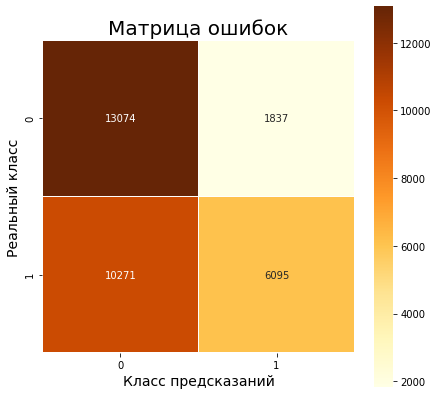

In [85]:
plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix(y_test, predictions_test),
            cmap='YlOrBr',
            square=True, 
            linewidths=0.1,
            annot=True,
            fmt='d'
           )
plt.title("Матрица ошибок", fontsize=20)
plt.xlabel('Класс предсказаний', fontsize=14)
plt.ylabel('Реальный класс', fontsize=14)
None

Таким образом, модель
- в 6095 случаях классифицирует True Positive класс и в 13074 случаях - True Negative класс;
- при этом, в 1837 случаях модель классифицирует False Positive класс и в 10271 случаях - False Negative класс.

Визуализируем влияние признаков на вероятнось ДТП согласно лучшей модели, построенной по алгоритму  CatBoostClassifier:

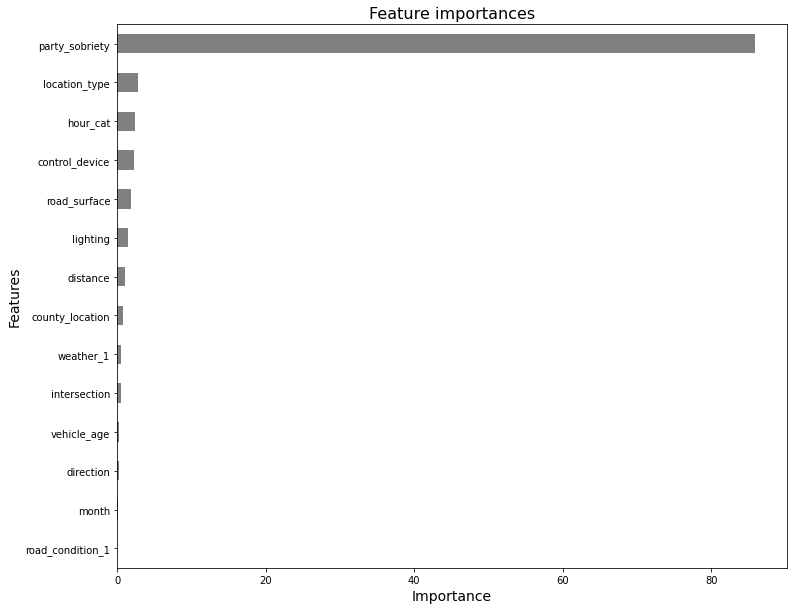

In [86]:
(abs(pd.Series(best_model.feature_importances_,
               index=best_model.feature_names_)
    )
 .sort_values()
 .plot(kind='barh',
       figsize=(12,10),
       color='grey'
      )
)
plt.title('Feature importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
None

Согласно модели трезвость водителя является критическим фактором, влияющим на вероятность попадания в ДТП, остальные признаки незначительны.

Ранее уже строили зависимость уровня трезвости водителя и целевой переменной, визуализируем еще раз:

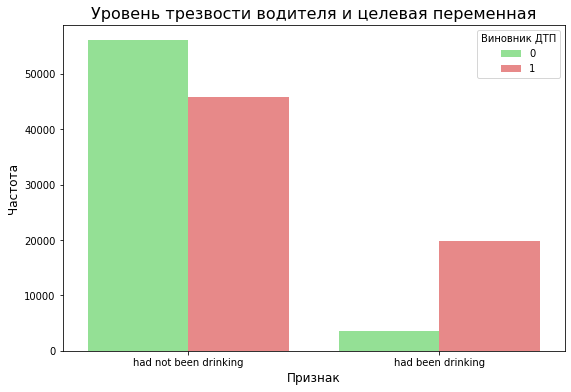

In [87]:
plt.figure(figsize=(9,6))
sobriety = df.groupby('at_fault')['party_sobriety'] \
             .value_counts() \
             .rename('count') \
             .reset_index()
sns.barplot(data = sobriety, y = 'count', x = 'party_sobriety', hue = 'at_fault')
plt.title('Уровень трезвости водителя и целевая переменная', fontsize=16)
plt.xlabel('Признак', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.legend(title='Виновник ДТП')
None

Водители в состоянии алкогольного опьянения в несколько раз чаще становятся виновниками ДТП, среди аварий с участием трезвых водителей - водитель чаще всего был невиновен.

Недопуск за руль нетрезвого водителя поможет значительно снизить риск ДТП и сократить убытки каршеринговой компании. Для этого необходимо оборудовать автомобиль газоанализатором для определения алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием для запуска двигателя. В качестве контроля проверки  установить в салоне камеру, направленную на водительское место. Также в договоре/оферте между сторонами прописать крупные штрафы водителям в случае нарушения процедуры проверки на трезвость.

## Выводы

В рамках данного проекта были рассмотрены модели, построенные по алгоритмам RandomForestClassifier, LGBMClassifier, CatBoostClassifier.

Был проведен подбор гиперпараметров моделей с помощью инструмента optuna. Наилучшей моделью оказалась модель, построенная по CatBoostClassifier, со следующими гиперпараметрами:
- objective='CrossEntropy',
- iterations=236.
- max_depth=7.
- early_stopping_rounds=24.
- learning_rate=0.005058818473689313.

Метрика качества ROC-AUC у данной модели на обучающей выборке получилась равной 0.6613, на тестовой выборке - 0.6246.

Также был проведен анализ влияния признаков на вероятнось ДТП согласно данной модели. Было выявлено, что трезвость водителя является критическим фактором, влияющим на вероятность попадания в ДТП, остальные признаки оказались незначительными. Поэтому для снижения риска ДТП и сокращения убытков в первую очередь каршеринговой компании необходимо предусмотреть ряд мер, направленных на недопуск нетрезвых водителей за руль, например:
- оборудовать автомобиль газоанализатором для определения алкогольного опьянения;
- оборудовать автомобиль системой запуска двигателя только при прохождении теста на опьянение;
- установить в салоне камеру, направленную на водительское место, для контроля проверки;
- в договоре/оферте между сторонами  прописать крупные штрафы в случае нарушения водителем процедуры проверки на трезвость.